In [1]:
import numpy as np
import pylab as pl
import random
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Problem 1: Gillespies algorithm

In [84]:
def sir_event(initial,time, params): 
    """We asumme inital conditions as integers and X,Y,Z ordered"""
    gamma, beta, mu = params[0], params[1], params[2]
    rates = np.zeros(6)
    N = sum(initial)
    initial = np.array(initial)
    rates[0] = mu*N  #Birth
    #Handling division by zero issues
    if initial[0] > 0 and initial[1] > 0:
        rates[1] = beta*initial[0]*initial[1]/N
    else:
        rates[1] = 0
    rates[2] = gamma*initial[1] #
    rates[3] = mu*initial[0]
    rates[4] = mu*initial[1]
    rates[5] = mu*initial[2]
    changes = np.array([[1,0,0],[-1, 1, 0], [0,-1, 1], [-1, 0, 0], [0, -1, 0], [0, 0 ,-1]])
    dtm = []
    for rate in rates:
        if rate == 0:
            dtm.append(1000)
        else:
            dtm.append(-np.log(np.random.rand())/rate)
    indx = np.argmin(dtm)
    dt = dtm[indx]
    event = np.array([initial + changes[indx]]).T
    return event, time + dt


def event_loop(tmax, initial, function, arguments):
    '''Keeps loop for '''
    time = [0]
    results = np.array([[value] for value in initial])
    k = 0
    while time[-1] < tmax:
        event, tn = function(initial, time[-1], arguments)
        results = np.concatenate((results, event), axis= 1)
        initial = event[:,0]
        time.append(tn)
        k += 10
        if k == 10:
#             print(time[-1])
            k = 0
    time = np.array(time)
    return time, results

(0.0, 30.0)

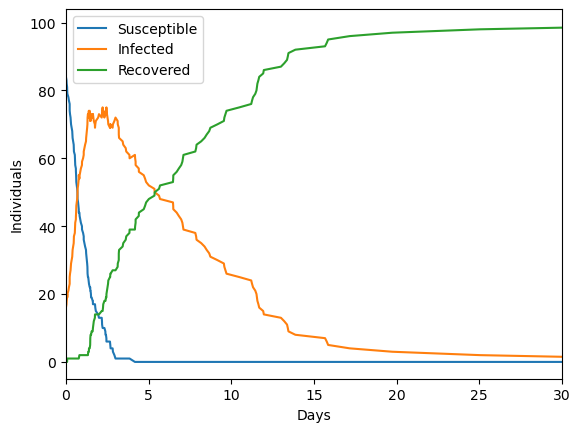

In [130]:
p =  [0.15, 2, 1/(365*60)]
N = 100

populations = np.round(100* np.array([0.85, 0.15, 0]))
x, y = event_loop(30, populations, sir_event,p )

# print(y[0;])
plt.plot(x, y[0,:], label = 'Susceptible')
plt.plot(x, y[1,:], label = 'Infected')
plt.plot(x, y[2,:], label = 'Recovered')

plt.xlabel('Days')
plt.ylabel('Individuals')
plt.legend()
plt.xlim(0, 30)

(array([110.,  28.,  17.,   2.,   8.,   2.,   0.,   3.,   2.,   1.]),
 array([6.81013400e-05, 4.88718492e-02, 9.76755971e-02, 1.46479345e-01,
        1.95283093e-01, 2.44086841e-01, 2.92890588e-01, 3.41694336e-01,
        3.90498084e-01, 4.39301832e-01, 4.88105580e-01]),
 <BarContainer object of 10 artists>)

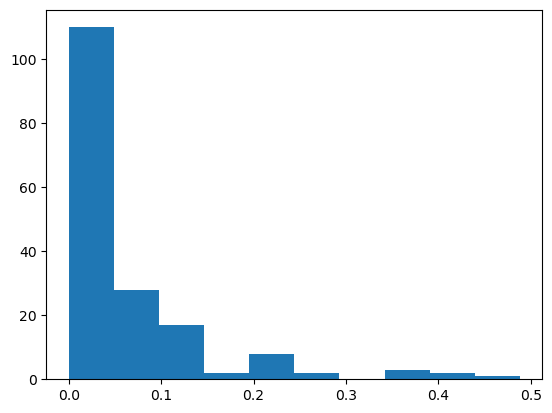

In [94]:
t= np.diff(x)
# print(t)
t = t[t < 0.5]
plt.hist(t)

## Investigating simulation variability

## Simulation variability and negative covariance

In [79]:
# We first define the deterministic SIR model

def SIR(initial, t, gamma, beta, mu):   
    Y = np.zeros(3) 
    Y[0] = mu - beta * initial[0] * initial[1] - mu * initial[0]
    Y[1] = beta * initial[0] * initial[1] - gamma * initial[1] - mu * initial[1]
    Y[2] = gamma * initial[1] - mu * initial[2]
    return Y   


First we run both deterministic and stochastic models for different R0's many times

In [148]:
#Setting model parameters
betas = np.linspace(1.5,10, 5)
gamma = 0.15
mu = 1/60*365
reproductive = betas/(mu+gamma)

# Seeting population size 
N = 100
populations = np.round(100* np.array([0.85, 0.15, 0]))
tmax = 20

# Setting time array for deterministic model
time = np.arange(0,tmax+1,1)


# First run stochastic model for different R0s for 10 times 
stoch_runs = {}
det_run = {}

# Outer loop which varies the beta we apply to both models
for indx, r0 in enumerate(reproductive) :
    print(f"Current R0: {r0}")
    temp = []
    beta = betas[indx]
    # Running stochastic model many times with same beta
    for k in range(3):
#         print(f"k = {k}")
        params = [gamma, beta, mu]
        tn, y = event_loop(tmax, populations, sir_event,params)
        temp.append([tn, y])
    #Saving stochastic results
    stoch_runs[r0] = temp
    print('Running deterministic model now')
    #Running and saving deterministic output
    det_output = odeint(SIR, populations, time, args = (gamma, beta, mu))
    det_run[r0] = [time, det_output]
    

Current R0: 0.24064171122994651
Running deterministic model now
Current R0: 0.5815508021390374
Running deterministic model now
Current R0: 0.9224598930481284
Running deterministic model now
Current R0: 1.2633689839572193
Running deterministic model now
Current R0: 1.6042780748663101
Running deterministic model now


### Calculating variance and covariance

In [149]:
sample_times = [0,5,10,20]

lst = []
# 1. Calculate average variance per reproductive number

variances = {}
covariances= {}

for r0 in stoch_runs:
    print(f"Reproductive number:{r0}")
    #We get runs for every R0
    runs = stoch_runs[r0]
    varS = []
    varI = []
    varR = []
    varComb = []
    covSI = [] #The covariance between susceptible and infected
    for run in runs:
        results = run[1]
        varS.append(np.var(results[0,:]) )
        varI.append(np.var(results[1,:]))
        varR.append(np.var(results[2,:]))
        varComb.append(np.average([varS[-1], varI[-1], varR[-1]]))
        #Covariances
        covSI.append(np.cov(results[0,:], results[1,:], rowvar=False)[0, 1])
    #Adding variances 
    variances[r0] = (np.average(varS), np.average(varI), np.average(varR), np.average(varComb))
    covariances[r0] = np.average(covSI)
    

Reproductive number:0.24064171122994651
Reproductive number:0.5815508021390374
Reproductive number:0.9224598930481284
Reproductive number:1.2633689839572193
Reproductive number:1.6042780748663101


### Comparing means between stochastic and deterministic model

In [175]:
sampling_times = np.linspace(0,10,20)

# Defining variables where 

def sampler(times,stoch_runs):
    final_dic = {}
    for key in stoch_runs:
        print(f"Current R0: {key}")
        #We set data for each R0 we have used
        runs = stoch_runs[key]
        Sn = [[] for x in times]
        In = [[] for x in times]
        Rn = [[] for x in times]
        for indx, t in enumerate(times):
            for run in runs:
                tn, data = run[0], run[1]
                time_differences = np.abs(tn-t)
                location_indx = np.argmin(time_differences)
                sample = data[:,location_indx]
                Sn[indx].append(sample[0])
                In[indx].append(sample[1])
                Rn[indx].append(sample[2])
#         print(len(Sn))
        S = [np.average(tn) for tn in Sn]
        I = [np.average(tn) for tn in In]
        R = [np.average(tn) for tn in Rn]
        #Adding data to dictionary for each R0
        final_dic[key] = np.array([S,I,R])
    return final_dic

stoch_samples = sampler(sampling_times, stoch_runs)




Current R0: 0.24064171122994651
Current R0: 0.5815508021390374
Current R0: 0.9224598930481284
Current R0: 1.2633689839572193
Current R0: 1.6042780748663101


In [176]:
keys = [k for k in stoch_samples]
print(keys)
print(reproductive)
# print(stoch_runs)
keys2 = [k for k in stoch_runs]
keys2

[0.24064171122994651, 0.5815508021390374, 0.9224598930481284, 1.2633689839572193, 1.6042780748663101]
[0.24064171 0.5815508  0.92245989 1.26336898 1.60427807]


[0.24064171122994651,
 0.5815508021390374,
 0.9224598930481284,
 1.2633689839572193,
 1.6042780748663101]

(20,)


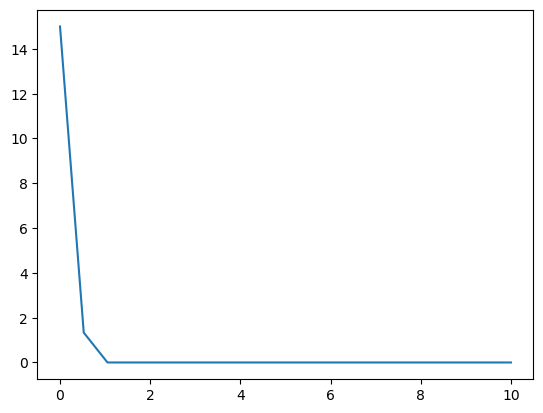

In [177]:
data = stoch_samples[0.24064171122994651]
print(data[1].shape)
plt.plot(sampling_times,data[1,:])

## Stochastic resonance and Increased transients

## Extinction events and critial community size

In [ ]:
# Define loop where we stop  when infection reaches extinction
def event_loop2(initial, function, arguments):
    '''Keeps loop for '''
    time = [0]
    results = np.array([[value] for value in initial])
    k = 0 
    while True:
        event, tn = function(initial, time[-1], arguments)
        results = np.concatenate((results, event), axis= 1)
        initial = event[:,0]
        time.append(tn)
        if event[1][0] == 0:
            break
    time = np.array(time)
    return time, results

### Effect of population size N

In [ ]:
# Run montecarlo simulation with one N and collect values --> Calculate median value per N value
beta = 1.5
gamma = 0.15
mu = 1/(60*365)
np.random.seed(69)

# Running loop for different Ns
Ns = np.logspace(1, 4, 6)
end_times = []

for j in range(len(Ns)):
    N = Ns[j]
    I0 = int(N * (0.25))
    S0 = int(N * 0.75)
    R0 = int(N * 0)
    initial = [S0, I0, R0]
    t = [] 
    print(f"Current N: {N}")
    for k in range(5):
#         print(f"Current k: {k}")
        initial = [S0, I0, R0]
        params = [gamma, beta, mu]
        times, results = event_loop2(initial, sir_event,params)
        t.append(times[-1])
    avg_time = np.average(t)
    end_times.append(avg_time)
    
plt.scatter(Ns, end_times)
plt.plot(Ns, end_times)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Population Size N')
plt.ylabel('Average extinction time')
# Run simulation for differnt N's , Run multiple times and compile all the final times

### Effect of R0

In [ ]:
# Setting random number seed
np.random.seed(69)

# Run montecarlo simulation with one N and collect values --> Calculate median value per N value
gamma = 0.15
mu = 1/(60*365)
betas = np.arange(gamma,3,0.3)

N = 100
I0 = int(N * (0.25))
S0 = int(N * 0.75)
R0 = int(N * 0)

Rp = betas/(gamma + mu)
end_times = []
for j in range(len(Rp)):
    beta = betas[j]
    print(Rp[j])
    params = [gamma, beta, mu]
    t = [] 
    for k in range(10):
        times, results = event_loop2(initial, sir_event,params)
        t.append(times[-1])
    avg_time = np.average(t)
    end_times.append(avg_time)
    
plt.scatter(Rp, end_times)
plt.plot(Rp, end_times)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$R_0$')
plt.ylabel('Average extinction time')

In [ ]:
plt.scatter(Rp, end_times)
plt.plot(Rp, end_times)
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel(r'$R_0$')
plt.ylabel('Average extinction time')

# Problem 2: Spatial models - Networks

In [ ]:
import networkx as nx
import ndlib
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc


## Implementing SIR on different networks: Barabasi Albert, Watts-Strogatz, Erdos-Reyni

In [ ]:
# Creating graphs
# n = 100
# m = 0.1
# seed = 69

# 'Scale free' network
barabasi = nx.barabasi_albert_graph(n, m, seed)
# erdos = nx.erdos_renyi_graph(n, p, seed=None, directed=False)

# 'Small world' network
# watts = nx.watts_strogatz_graph(n, k, p, seed=None) 

# # Model selection
# model1 = ep.SIRModel(erdos)

# # Model Configuration
# cfg = mc.Configuration()
# cfg.add_model_parameter('beta', 1.5)
# cfg.add_model_parameter('gamma', 0.5)
# cfg.add_model_parameter("fraction_infected", 0.05)
# model1.set_initial_status(cfg)

# models

In [ ]:
# 1.Load diffent network types, 
# 2.For each network type do three runs with different R0
# 3


In [ ]:
print(1/7)

## Generating equivalent networks

## Simulating SIR spread through networks

## Real data: Applying dynamic Vaccination strategy 

### Steps:
1.Load graph data
2.Instantiate sIR model into graph
3.


In [ ]:
test = nx.barabasi_albert_graph(5, 1, 3)

dic = test.degree()
print(dic)
# G.degree[0]

In [ ]:
print(-np.log(0))
x = np.linspace

In [15]:
print(np.argmin(['-inf', 2 ,3 ]))

0


In [16]:
0.3/0.00000000001

30000000000.0

In [104]:
dataset = [1, 2, 3, 4, 5]
variance = np.var(dataset)
print(variance)

2.0


In [127]:
g = [[], [], []]
g[0].append([1,2,3])
g

[[[1, 2, 3]], [], []]